In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from collections import defaultdict
from copy import deepcopy

# constants
# DATA_LOC = "/home/ubuntu/projects/datasets/AP_train.txt"
DATA_LOC = "/Users/sahilgandhi/Datasets/AP_train.txt"

# data formats
FORMAT_ID = "#index"
FORMAT_PAPER_TITLE = "#*"
FORMAT_AUTHORS = "#@"
FORMAT_YEAR = "#t"
FORMAT_VENUE = "#c"
FORMAT_REFERENCES = "#%"
FORMAT_ABSTRACT = "#!"

# data keys
ID = "id"
TITLE = "title"
AUTHOR = "author"
YEAR = "year"
VENUE = "venue"
REFERENCE = "reference"
ABSTRACT = "abstract"

In [6]:
def generatetables():
    main_table = list()
    author_table = list()
    reference_table = list()
    datum = dict()
    with open(DATA_LOC, "r", encoding='utf-8') as file:
        for line in file.readlines():            
            if FORMAT_ID in line:
                # yield already existing datum and continue
                if len(datum.keys()) > 0:
                    main_table.append(datum)
                datum = dict() # re-initialize local datum
                datum[ID] = line.strip(FORMAT_ID).strip()
            elif FORMAT_PAPER_TITLE in line[:10]:
                datum[TITLE] = line.strip(FORMAT_PAPER_TITLE).strip()
            elif FORMAT_REFERENCES in line[:10]:
                reference_table.append({ID: datum[ID], REFERENCE: line.strip(FORMAT_REFERENCES).strip()})
            elif FORMAT_AUTHORS in line[:10]: 
                for author in line.strip(FORMAT_AUTHORS).strip().split(';'):
                    author_table.append({ID: datum[ID], AUTHOR: author.strip()})                    
            elif FORMAT_YEAR in line[:10]: 
                datum[YEAR] = line.strip(FORMAT_YEAR).strip()
            elif FORMAT_VENUE in line[:10]: 
                datum[VENUE] = line.strip(FORMAT_VENUE).strip()
            elif FORMAT_ABSTRACT in line[:10]: 
                datum[ABSTRACT] = line.strip(FORMAT_ABSTRACT).strip()
    return main_table, author_table, reference_table

# generate all tables
main, author, cit = generatetables()


In [8]:
# combine all tables and compute data
main_df = pd.DataFrame(main, columns={ID, TITLE, YEAR, VENUE, ABSTRACT})
author_df = pd.DataFrame(author, columns={ID, AUTHOR})
ref_df = pd.DataFrame(cit, columns={ID, REFERENCE})

consolidated = main_df.merge(author_df, how='outer', on=ID).merge(ref_df, how='outer', on=ID)

print('''
Length of Main DF: {0}\n
Length of Author DF: {1}\n
Length of References DF: {2}\n
Length of Consolidated DF: {3}
'''.format(len(main_df), len(author_df), len(ref_df), len(consolidated)))


Length of Main DF: 1976814

Length of Author DF: 4909848

Length of References DF: 7250326

Length of Consolidated DF: 23565622



### A. Compute the number of distinct authors, publication venues, publications, and citations/references

In [9]:
# distinct authors
print('''
Distinct Authors: {0}\n
Distinct Publication venues: {1}\n
Distinct Publications: {2}\n
Distinct references: {3}
'''.format(
    len(author_df.author.unique()),
    len(main_df.venue.unique()),
    len(main_df.title.unique()),
    len(ref_df.reference.unique())
))


Distinct Authors: 1478734

Distinct Publication venues: 255686

Distinct Publications: 1929486

Distinct references: 871089



### B. Are these numbers likely to be accurate? As an example look up all the publications venue names associated with the conference “Principles and Practice of Knowledge Discovery in Databases”13 – what do you notice?

In [10]:
main_df[main_df.venue.str.contains('Principles and Practice of Knowledge Discovery in Databases')][:5]

,title,abstract,year,venue,id
799595,Summarization of dynamic content in web collec...,This paper describes a new research proposal o...,2004,PKDD '04 Proceedings of the 8th European Confe...,799597
799732,Proceedings of the 8th European Conference on ...,NaN,2004,PKDD '04 Proceedings of the 8th European Confe...,799734
799733,Random matrices in data analysis,We show how carefully crafted random matrices ...,2004,PKDD '04 Proceedings of the 8th European Confe...,799735
799734,Data privacy,There is increasing need to build information ...,2004,PKDD '04 Proceedings of the 8th European Confe...,799736
799735,Breaking through the syntax barrier: searching...,The next wave in search technology will be dri...,2004,PKDD '04 Proceedings of the 8th European Confe...,799737


No, the results are not accurate. As we can see in the results above, the strings have some form of 'year' mentioned in them. So even if the actual venue is not different, the string representation of the venue changes because of the change in the year/date.

### C. For each author, construct the list of publications. Plot a histogram of the number of publications per author (use a logarithmic scale on the y axis)

In [12]:
_pubs, _authors = author_df[author_df.author != ''].sort_values([AUTHOR]).values.T

In [13]:
_keys, _indices = np.unique(_authors, True)

In [14]:
author_pubs = pd.DataFrame({AUTHOR: _keys, 'publications': [list(x) for x in np.split(_pubs, _indices[1:])], 'pub_count': [len(list(x)) for x in np.split(_pubs, _indices[1:])]})

KeyboardInterrupt: 

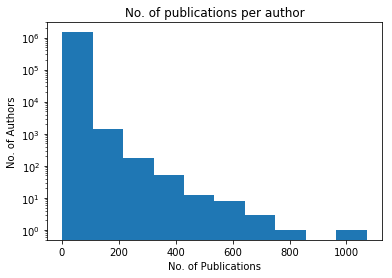

In [7]:
plt.hist(author_pubs['pub_count'], log=True, bins=50)
plt.xlabel('No. of Publications')
plt.ylabel('No. of Authors')
plt.title('No. of publications per author')
plt.show()

### D. Calculate the mean and standard deviation of the number of publications per author. Also calculate the Q1 (1st quartile14), Q2 (2nd quartile, or median) and Q3 (3rd quartile) values.

In [8]:
author_pubs['pub count'].describe()

count    1.478736e+06
mean     3.291781e+00
std      8.871884e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.071000e+03
Name: pub count, dtype: float64

#### Compare the median to the mean and explain the difference between the two values based on the standard deviation and the 1st and 3rd quartiles.

The vast difference between the median and the mean is because the max is very high which skews the mean, but the majority of the authors have 'no. of publications' closer to 1 (the median).

### E. Now plot a histogram of the number of publications per venue..

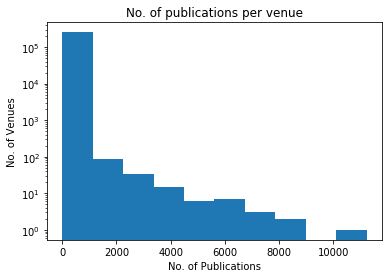

In [9]:
_pubs, _venues = main_df[main_df[VENUE] != ''][[ID, VENUE]].sort_values([VENUE]).values.T
_keys, _indices = np.unique(_venues, True)
venue_pubs = pd.DataFrame({VENUE: _keys, 'publications': [list(x) for x in np.split(_pubs, _indices[1:])], 'pub_count': [len(list(x)) for x in np.split(_pubs, _indices[1:])]})

plt.hist(venue_pubs['pub_count'], log=True)
plt.xlabel('No. of Publications')
plt.ylabel('No. of Venues')
plt.title('No. of publications per venue')
plt.show()

#### ...as well as calculate the mean, standard deviation, median, Q1, and Q3 values...

In [10]:
venue_pubs['pub_count'].describe()

count    255689.000000
mean          7.730841
std          83.380244
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max       11227.000000
Name: pub_count, dtype: float64

#### ...What is the venue with the largest number of publications in the dataset?

In [11]:
venue_pubs.sort_values(['pub_count'], ascending=False)[:1]

,pub_count,publications,venue
111545,11227,"[1816348, 1815264, 1815265, 1815266, 1816349, ...",IEEE Transactions on Information Theory


#### F. Plot a histogram of the number of references (number of publications a publication refers to) and citations (number of publications referring to a publication) per publication. 

In [12]:
publication_cits = ref_df[ref_df[REFERENCE] != ''].groupby([REFERENCE])[ID].count().reset_index(name='cit_count')
publication_refs = ref_df.groupby([ID])[REFERENCE].count().reset_index(name='ref_count')

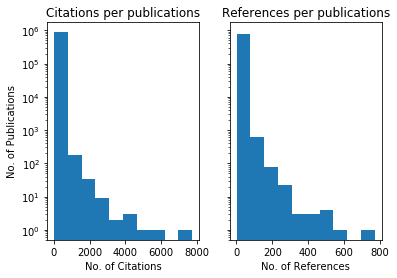

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.hist(publication_cits['cit_count'], log=True)
ax1.set_xlabel('No. of Citations')
ax1.set_ylabel('No. of Publications')
ax1.set_title('Citations per publications')

ax2.hist(publication_refs['ref_count'], log=True)
ax2.set_xlabel('No. of References')
ax2.set_title('References per publications')

plt.show()

#### ...What is the publication with the largest number of references?

In [53]:
publication_refs.sort_values(['ref_count'], ascending=False)[:5]

,id,ref_count
665804,719353,772
110251,1221204,555
322076,1583653,527
195056,1376720,524
110250,1221200,523


In [54]:
main_df[main_df['id'] == '719353']

,title,id,abstract,year,venue
719351,Cited References,719353,NaN,2003,Computer algebra handbook


In [68]:
publication_refs['ref_count'].describe()

count    797456.000000
mean          9.091822
std           8.725261
min           1.000000
25%           3.000000
50%           7.000000
75%          12.000000
max         772.000000
Name: ref_count, dtype: float64

#### What is the publication with the largest number of citations?

In [55]:
publication_cits.sort_values(['cit_count'], ascending=False)[:5]

,reference,cit_count
526606,408396,7753
512286,369236,5891
403026,190581,4748
180759,136350,4399
309887,168251,4336


In [56]:
main_df[main_df['id'] == '408396']

,title,id,abstract,year,venue
408394,Computers and Intractability: A Guide to the T...,408396,NaN,1979,Computers and Intractability: A Guide to the T...


In [67]:
publication_cits['cit_count'].describe()

count    871091.000000
mean          8.323273
std          33.892868
min           1.000000
25%           1.000000
50%           3.000000
75%           7.000000
max        7753.000000
Name: cit_count, dtype: float64

#### G. Calculate the so called “impact” factor for each venue. To do so, calculate the total number of citations for the publications in the venue, and then divide this number by the number of publications for the venue. Plot a histogram of the results

In [57]:
# impact = average citation for venue

pub_cit_dict = {row.reference:row.cit_count for row in publication_cits.itertuples()}

impact = list()
for row in venue_pubs.itertuples():
    tmp_dict = {VENUE: row.venue}
    _lst = list()
    for id in row.publications:
        _val = pub_cit_dict.get(id, None)
        if _val:
            _lst.append(_val)
    tmp_dict.update({'impact': 0 if len(_lst) == 0 else sum(_lst)/float(len(_lst))})
    impact.append(tmp_dict)


In [2]:
plt.hist([x['impact'] for x in impact], log=True)
plt.xlabel('Impact')
plt.ylabel('No. of Venues')
plt.title('Impact per venue')
plt.show()

NameError: name 'plt' is not defined

#### H. What is the venue with the highest apparent impact factor? 

In [63]:
sorted(impact, key=lambda x:x['impact'], reverse=True)[:1]

[{'impact': 7753.0,
  'venue': 'Computers and Intractability: A Guide to the Theory of NP-Completeness'}]

#### Do you believe this number? (http://mdanderson.libanswers.com/faq/26159)

In [130]:
tenplus = sorted(impact, key=lambda x:x['impact'])
for index, row in enumerate(tenplus):
    if row['impact'] <= 10:
        continue
    break
tenplus = tenplus[index:]
print(len(tenplus))
print(len(impact))
print(len(tenplus)/len(impact))

13763
255689
0.0538271102785024


About 5% of the journals have a 10+ impact factor. This is different than benchmarks given on the reference link. 

#### I. Now repeat the calculation from item b., but restrict the calculation to venues with at least 10 publications. How does your histogram change? 

In [64]:
pub_cit_dict = {row.reference:row.cit_count for row in publication_cits.itertuples()}

restricted_impact = list()
for row in venue_pubs.itertuples():
    if len(row.publications) < 10 :
        continue
    tmp_dict = {VENUE: row.venue}
    _lst = list()
    _raw= list()
    for id in row.publications:
        _val = pub_cit_dict.get(id, None)
        if _val:
            _raw.append({'publication': id, 'citation_count': _val})
            _lst.append(_val)
    tmp_dict.update({'impact': 0 if len(_lst) == 0 else sum(_lst)/float(len(_lst)),
                     'raw': _raw})
    restricted_impact.append(tmp_dict)

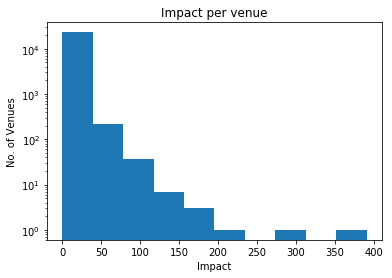

In [65]:
plt.hist([x['impact'] for x in restricted_impact], log=True)
plt.xlabel('Impact')
plt.ylabel('No. of Venues')
plt.title('Impact per venue')
plt.show()

#### List the citation counts for all publications from the venue with the highest impact factor.

In [66]:
sorted(restricted_impact, key=lambda x:x['impact'], reverse=True)[:1]

[{'impact': 391.0,
  'raw': [{'citation_count': 83, 'publication': '740918'},
   {'citation_count': 40, 'publication': '740917'},
   {'citation_count': 53, 'publication': '740914'},
   {'citation_count': 982, 'publication': '740915'},
   {'citation_count': 19, 'publication': '740913'},
   {'citation_count': 1169, 'publication': '740916'}],
  'venue': 'Computational Linguistics - Special issue on using large corpora: II'}]

#### How does the impact factor (mean number of citations) compare to the median number of citations?

The difference mainly stems from the same reason we see a difference in results part H and part I. When we restricted the data to contain venues that had atleast 10 publications, we eliminated outlier venues that had few publications with very high citation count. The median for such outliers is small, but they have a large mean. 

#### J. Finally, construct a list of publications for each publication year. Use this list to plot the average number of references and average number of citations per publication as a function of time. Explain the differences you see in the trends.

In [82]:
# _pubs, _years = main_df[main_df[YEAR] != ''][[ID, YEAR]].sort_values([YEAR]).values.T
_pubs, _years = main_df[pd.to_numeric(main_df[YEAR], errors='coerce').notnull()][[ID, YEAR]].sort_values([YEAR]).values.T
_keys, _indices = np.unique(_years, True)
yearly_pubs = pd.DataFrame({YEAR: _keys, 'publications': [list(x) for x in np.split(_pubs, _indices[1:])], 'pub_count': [len(list(x)) for x in np.split(_pubs, _indices[1:])]})
yearly_pubs['avg_references'] = pd.Series(np.zeros(len(yearly_pubs['pub_count'])), index=yearly_pubs.index)
yearly_pubs['avg_citations'] = pd.Series(np.zeros(len(yearly_pubs['pub_count'])), index=yearly_pubs.index)
yearly_pubs.head()

,pub_count,publications,year,avg_references,avg_citations
0,1,[716945],1936,0.0,0.0
1,1,[837644],1938,0.0,0.0
2,1,[683820],1941,0.0,0.0
3,1,[840607],1945,0.0,0.0
4,1,[683919],1947,0.0,0.0


In [86]:
pub_cit_dict = {row.reference:row.cit_count for row in publication_cits.itertuples()}
pub_ref_dict = {row.id:row.ref_count for row in publication_refs.itertuples()}

for index, row in enumerate(yearly_pubs.itertuples()):
    pub_ref_counts = [pub_ref_dict.get(x, 0) for x in row.publications]
    pub_cit_counts = [pub_cit_dict.get(x, 0) for x in row.publications]
    yearly_pubs.set_value(index, 'avg_references', sum(pub_ref_counts)/len(pub_ref_counts))
    yearly_pubs.set_value(index, 'avg_citations', sum(pub_cit_counts)/len(pub_cit_counts))

yearly_pubs.head()

,pub_count,publications,year,avg_references,avg_citations
0,1,[716945],1936,0.0,0.0
1,1,[837644],1938,0.0,6.0
2,1,[683820],1941,0.0,0.0
3,1,[840607],1945,0.0,19.0
4,1,[683919],1947,0.0,0.0


In [87]:
yearly_pubs['avg_references'].describe()

count    69.000000
mean      1.555866
std       1.598308
min       0.000000
25%       0.346037
50%       1.115393
75%       1.689493
max       5.966628
Name: avg_references, dtype: float64

In [88]:
yearly_pubs['avg_citations'].describe()

count    69.000000
mean      4.059049
std       2.746188
min       0.000000
25%       2.425926
50%       4.438535
75%       5.489140
max      19.000000
Name: avg_citations, dtype: float64

In [121]:
sorted_yearly_pubs = yearly_pubs.sort_values([YEAR])

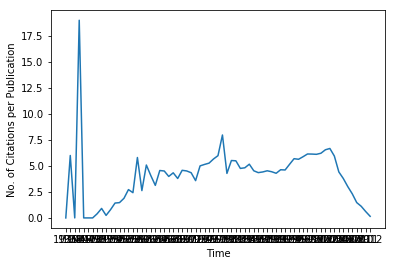

In [122]:
plt.plot(sorted_yearly_pubs[YEAR], sorted_yearly_pubs['avg_citations'])
plt.xlabel('Time')
plt.ylabel('No. of Citations per Publication')
plt.show()

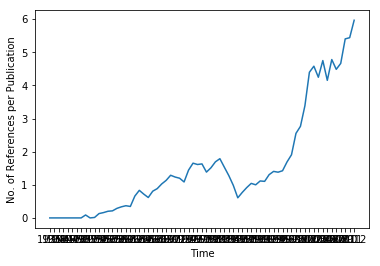

In [124]:
plt.plot(sorted_yearly_pubs[YEAR], sorted_yearly_pubs['avg_references'])
plt.xlabel('Time')
plt.ylabel('No. of References per Publication')
plt.show()